In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/Users/liibanmohamud/Desktop/scikit-jax/data/Student_performance_data _.csv')
data = data.drop(columns=['StudentID', 'StudyTimeWeekly', 'GPA', 'Absences'])

In [3]:
data.head()

,Age,Gender,Ethnicity,ParentalEducation,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GradeClass
0,17,1,0,2,1,2,0,0,1,0,2.0
1,18,0,0,1,0,1,0,0,0,0,1.0
2,15,0,2,3,0,2,0,0,0,0,4.0
3,17,1,0,3,0,3,1,0,0,0,3.0
4,17,1,0,2,1,3,0,0,0,0,4.0


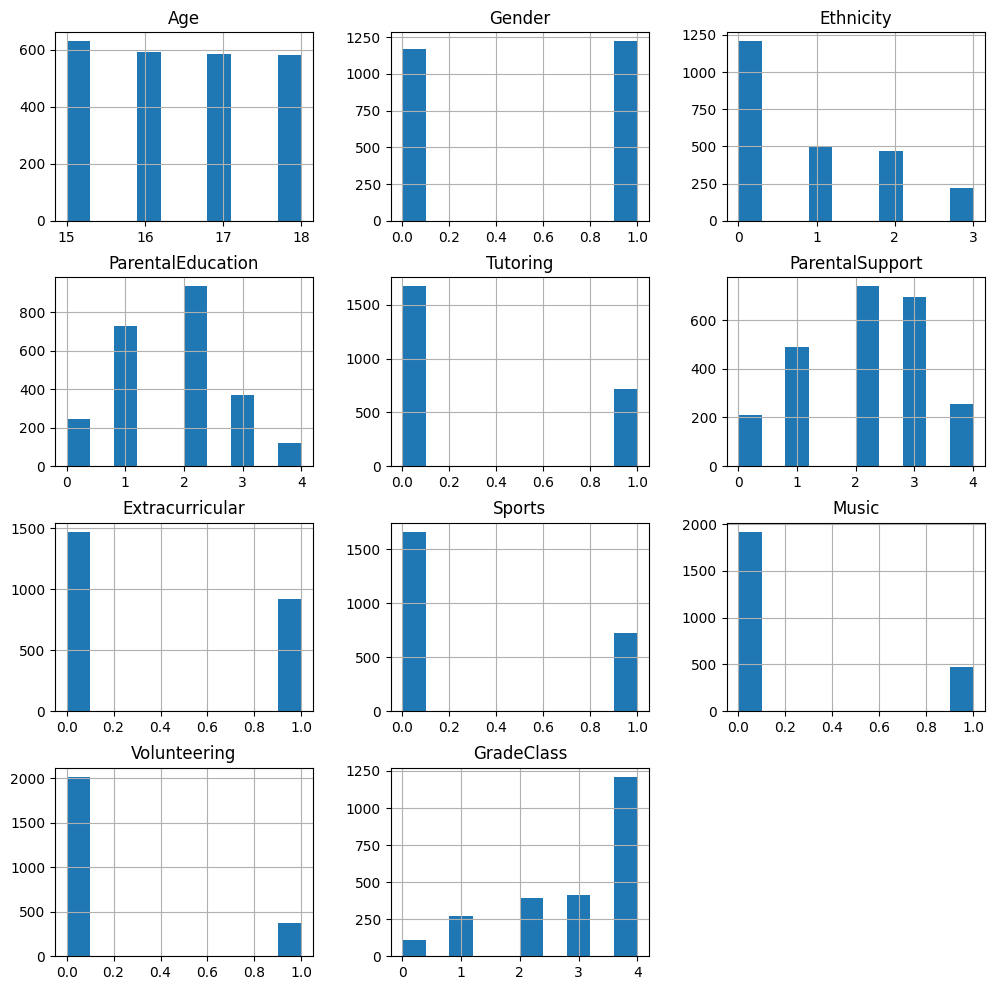

In [4]:
data.hist(figsize=(12,12))
plt.show()

In [5]:
X = data.drop(columns=['GradeClass']).to_numpy()
y = data['GradeClass'].to_numpy()

X, y = map(jnp.array, (
    X, y
))

X.shape

(2392, 10)

In [6]:
def split_data(data, val_size=0.1, test_size=0.2):
    """ 
    Splits data.
    """
    split_index_test = int(len(data) * (1-test_size))

    data_non_test = data[:split_index_test]
    data_test = data[split_index_test:]

    split_index_val = int(len(data_non_test) * (1-val_size))

    data_train = data_non_test[:split_index_val]
    data_val = data_non_test[split_index_val:]

    return data_train, data_val, data_test

In [7]:
(X_train, X_val, X_test), (y_train, y_val, y_test) = map(
    split_data,
    (X, y)
)

data_matrix = jnp.array(data.to_numpy())
data_matrix

Array([[17.,  1.,  0., ...,  1.,  0.,  2.],
       [18.,  0.,  0., ...,  0.,  0.,  1.],
       [15.,  0.,  2., ...,  0.,  0.,  4.],
       ...,
       [16.,  1.,  0., ...,  0.,  1.,  2.],
       [16.,  1.,  1., ...,  1.,  0.,  1.],
       [16.,  1.,  0., ...,  0.,  1.,  1.]], dtype=float32)

In [8]:
from typing import Optional

In [9]:
data_train = jnp.hstack((X_train, y_train[:, None]))

In [10]:
from collections import Counter
from itertools import combinations

list(combinations(X_train.T, 2))

[(Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([1, 0, 0, ..., 1, 1, 1], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([0, 0, 2, ..., 1, 1, 0], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([2, 1, 3, ..., 2, 0, 0], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([1, 0, 0, ..., 0, 1, 0], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([2, 1, 2, ..., 3, 4, 2], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([0, 0, 0, ..., 0, 1, 1], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([1, 0, 0, ..., 0, 0, 0], dtype=int32)),
 (Array([17, 18, 15, ..., 16, 15, 16], dtype=int32),
  Array([0, 0, 0, ..., 0, 1, 1], dtype=int32)),
 (Array([1, 0, 0, ..., 1, 1, 1], dtype=int32),
  Array([0, 0, 2, ..., 1, 1, 0], dtype=int32

In [11]:
def compute_marginal_likelihood(X:jax.Array):
    n_features = X.shape[1]
    marginal_likelihood = []

    for j in range(n_features):
        unique_categories = jnp.unique(X[:,j])
        feature_counts = {category: jnp.mean(X[:,j] == category).item() for category in unique_categories.tolist()}
        marginal_likelihood.append(feature_counts)
    
    return marginal_likelihood

In [12]:
marginal_likelihoods = compute_marginal_likelihood(X)
marginal_likelihoods[0][15]

0.26337793469429016

In [13]:
def obtain_priors(y:jax.Array):
    """
    Obtain prior probabilities.
    """
    unique_classes = jnp.unique(y)
    prior_probabilities = jnp.zeros_like(unique_classes)
    
    for index, class_ in enumerate(unique_classes.tolist()):
        prior_probabilities = prior_probabilities.at[index].set(jnp.mean(jnp.where(y==class_, 1, 0)))

    return prior_probabilities

In [14]:
priors = obtain_priors(y_train)
priors

Array([0.03137711, 0.10575247, 0.16327716, 0.17315514, 0.5264381 ],      dtype=float32)

In [15]:
def obtain_likelihoods(X:jax.Array, y:jax.Array, alpha:int=0):
    """
    Obtains likelihoods.
    """
    unique_classes = jnp.unique_values(y)
    unique_categories_in_every_feature = [jnp.unique(x).tolist() for x in X.T]
    collection_of_indices_of_each_class = [jnp.where(y==class_) for class_ in unique_classes.tolist()]
    likelihoods_of_each_class_per_category = {class_: [] for class_ in unique_classes.tolist()}

    for class_, collection_of_indices in zip(unique_classes.tolist(), collection_of_indices_of_each_class):
        for j, categories in enumerate(unique_categories_in_every_feature):
            likelihoods_per_feature = [(jnp.sum(jnp.where(X[collection_of_indices][:,j]==category, 1, 0)) + alpha) / (len(X[collection_of_indices][:,j]) + alpha * X.shape[1]) for category in categories]
            likelihoods_of_each_class_per_category[class_].append({category: likelihoods_per_feature[ith_category].item() for ith_category, category in enumerate(categories)})
        
    return likelihoods_of_each_class_per_category

likelihoods = obtain_likelihoods(X_train, y_train)
likelihoods

{0.0: [{15: 0.2222222238779068,
   16: 0.31481480598449707,
   17: 0.20370370149612427,
   18: 0.25925925374031067},
  {0: 0.46296295523643494, 1: 0.5370370149612427},
  {0: 0.3888888955116272,
   1: 0.2777777910232544,
   2: 0.25925925374031067,
   3: 0.07407407462596893},
  {0: 0.14814814925193787,
   1: 0.2777777910232544,
   2: 0.4444444477558136,
   3: 0.1111111119389534,
   4: 0.018518518656492233},
  {0: 0.46296295523643494, 1: 0.5370370149612427},
  {0: 0.03703703731298447,
   1: 0.0555555559694767,
   2: 0.20370370149612427,
   3: 0.4444444477558136,
   4: 0.25925925374031067},
  {0: 0.40740740299224854, 1: 0.5925925970077515},
  {0: 0.6296296119689941, 1: 0.37037035822868347},
  {0: 0.6851851940155029, 1: 0.31481480598449707},
  {0: 0.8518518805503845, 1: 0.14814814925193787}],
 1.0: [{15: 0.28021979331970215,
   16: 0.2637362778186798,
   17: 0.2252747267484665,
   18: 0.23076923191547394},
  {0: 0.5, 1: 0.5},
  {0: 0.5054945349693298,
   1: 0.23076923191547394,
   2: 0.1813

In [16]:
X_test[2].tolist()

[16, 1, 1, 1, 0, 1, 1, 0, 1, 0]

In [17]:
X_train.shape

(1721, 10)

In [18]:
likelihoods[0][0]

{15: 0.2222222238779068,
 16: 0.31481480598449707,
 17: 0.20370370149612427,
 18: 0.25925925374031067}

In [19]:
x = X_test[0]
print(f'x : {x}')
jnp.log(priors[1]) + jnp.sum(jnp.log(jnp.array([likelihoods[1][i][x[i].item()] for i in range(len(x))])))

x : [16  1  0  1  0  3  0  1  0  0]


Array(-9.870249, dtype=float32)

In [20]:
len(marginal_likelihoods)

10

In [21]:
def predict(X_test:jax.Array, priors:jax.Array, likelihoods:dict, marginal_likelihoods:list):
    """ 
    predict on test data
    """
    vector_of_posteriors_for_data_point_i = jnp.zeros(len(likelihoods))
    matrix_of_posteriors = []

    for index, x in enumerate(X_test):
        for i, class_ in enumerate(likelihoods.keys()):
            posterior = jnp.log(priors[i]) + jnp.sum(jnp.log(jnp.array([likelihoods[i][j][x_ij.item()] for j, x_ij in enumerate(x)]))) 
            vector_of_posteriors_for_data_point_i = vector_of_posteriors_for_data_point_i.at[i].set(posterior)
        matrix_of_posteriors.append(vector_of_posteriors_for_data_point_i)

    y_pred = jnp.argmax(jnp.array(matrix_of_posteriors), axis=1)
    return y_pred

In [22]:
y_pred = predict(X_val, priors, likelihoods, marginal_likelihoods)
y_pred

Array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [23]:
from skjax.dimensionality_reduction import PCA

ModuleNotFoundError: No module named 'skjax'